# AI Tool for Actuaries
## Chapter 7: Gradient boosting machines (GBMs)
## Authors: Michael Mayer and Mario Wuthrich
## Version May 2025


This Jupyter notebook applies LightGBM to the French MTPL data, both frequencies and severities

In [2]:
# Import required libraries
import lightgbm as lgb        # lightgbm package
import numpy as np            # numpy package
import pandas as pd           # pandas package
import shap                   # shap package: for SHAP visualizations
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

In [4]:
# Load and inspect the data (this dataset contains counts and severities)
df = pd.read_parquet("../../Data/freMTPL2freq.parquet")
df.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L


In [5]:
# Preprocessing of features mainly to improve interpretability
df1 = df.assign(
    frequency=lambda x: x.ClaimNb / x.Exposure,
    severity=lambda x: (x.ClaimTotal / x.ClaimNb).clip(0, 5e4),
    VehAge=lambda x: x.VehAge.clip(0, 25),         # censoring at 25 years
    lDensity=lambda x: np.log(x.Density),          # log-transform is not needed for GBM, but it improves visualization in SHAP
    Region=lambda x: x.Region.cat.set_categories(  # keep only biggest levels
        ["R11", "R24", "R52", "R53", "R82", "R93", "Other"]
    ).fillna("Other"),
    VehBrand=lambda x: x.VehBrand.cat.set_categories(  # keep only biggest levels
        ["B1", "B2", "B3", "B5", "B12", "Other"]
    ).fillna("Other"),
)

## Frequency model
We start with a Poisson claims frequency model

In [6]:
# learning and test sample split (identical to Wuthrich-Merz, Springer 2023)
learn, test = (df1[df1.LearnTest == x] for x in ["L", "T"])

In [7]:
# Turn categories to numbers
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", ["DrivAge", "lDensity", "VehAge", "VehPower"]),
        ("cat", OrdinalEncoder(), ["Region", "VehBrand", "VehGas"]),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [9]:
# Parameters found by randomized search five-fold CV on the training data,
# using early stopping to determine the number of rounds (not shown for brevity)
params_freq = {
    "objective": "poisson",
    "learning_rate": 0.02,
    "num_leaves": 15,
    "reg_lambda": 2.5,
    "reg_alpha": 4,
    "colsample_bynode": 0.8,
    "subsample": 0.8,
    "min_child_samples": 100,
    "min_split_gain": 0.001,
    "poisson_max_delta_step": 0.1,
}
nrounds_freq = 527

# We use the Scikit-Learn API of LightGBM
lgb_freq = LGBMRegressor(
    **params_freq, n_estimators=nrounds_freq, importance_type="gain", random_state=5
)
model_freq = Pipeline([("preprocessor", preprocessor), ("model", lgb_freq)])

# Fit model
_ = model_freq.fit(X=learn, y=learn.frequency, model__sample_weight=learn.Exposure)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 610206, number of used features: 7
[LightGBM] [Info] Start training from score -2.608692


Next we compute the in-sample and out-of-sample Poisson deviance losses. These results should not be compared to the network ones, because we did not consider all covariates in this LightGBM example (for getting nicer SHAP plots below).

In [12]:
# define the Poisson deviance (scaled by 10^2 for better visibility)
def poisson_deviance(pred, obs, weight):
    return 100 * 2* (np.sum(pred) - np.sum(obs) + np.sum(np.log((obs/pred)**obs))) / np.sum(weight)

test_pred  = model_freq.predict(test)*test.Exposure
learn_pred = model_freq.predict(learn)*learn.Exposure

print("Poisson Deviance (Train, Test):", 
      round(poisson_deviance(learn_pred, learn.ClaimNb, learn.Exposure), 3),
      round(poisson_deviance(test_pred, test.ClaimNb, test.Exposure), 3))

Poisson Deviance (Train, Test): 46.431 46.898


### Split gain: variable importance measure

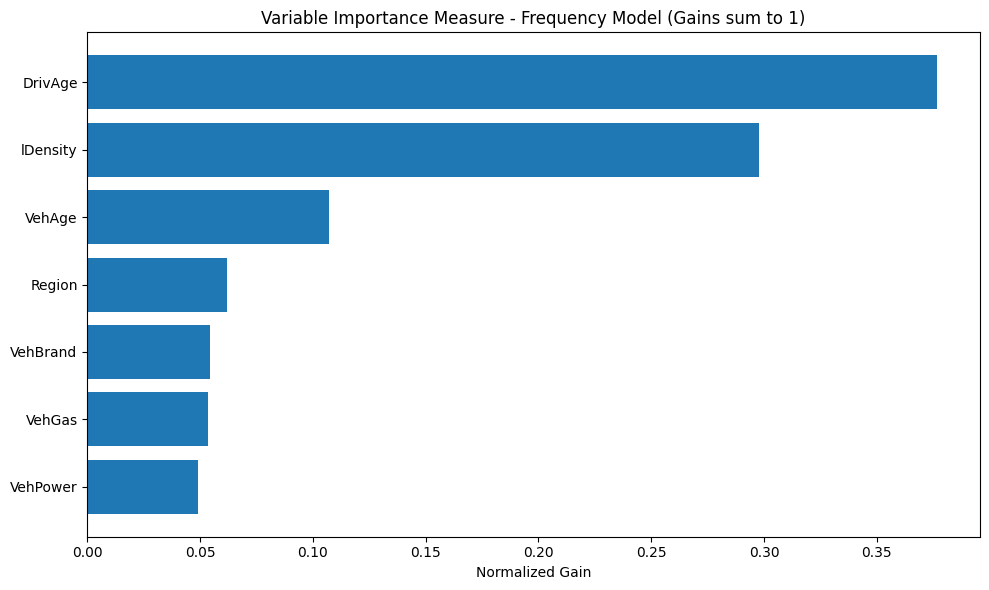

In [13]:
import matplotlib.pyplot as plt

# Get feature importance values
importance_values = model_freq[-1].feature_importances_
# Normalize the importance values
importance_values = importance_values / importance_values.sum()

# Sort values and names in descending order
sorted_idx = importance_values.argsort()  # Get indices for descending order
sorted_values = importance_values[sorted_idx]
sorted_names = [model_freq[-1].feature_name_[i] for i in sorted_idx]

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_values)), sorted_values)
plt.yticks(range(len(sorted_values)), sorted_names)
plt.xlabel('Normalized Gain')
plt.title('Variable Importance Measure - Frequency Model (Gains sum to 1)')
plt.tight_layout()
plt.show()

### SHAP analysis on log scale
For details, see notebook on SHAP

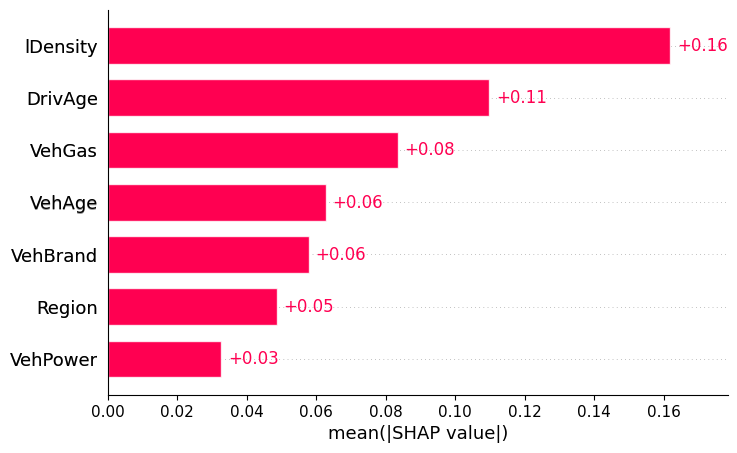

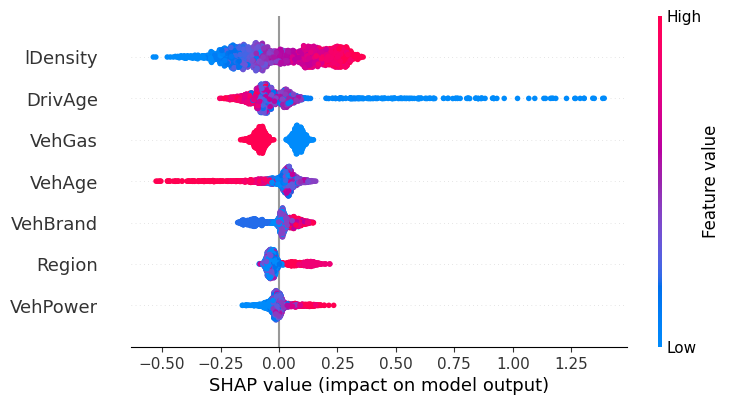

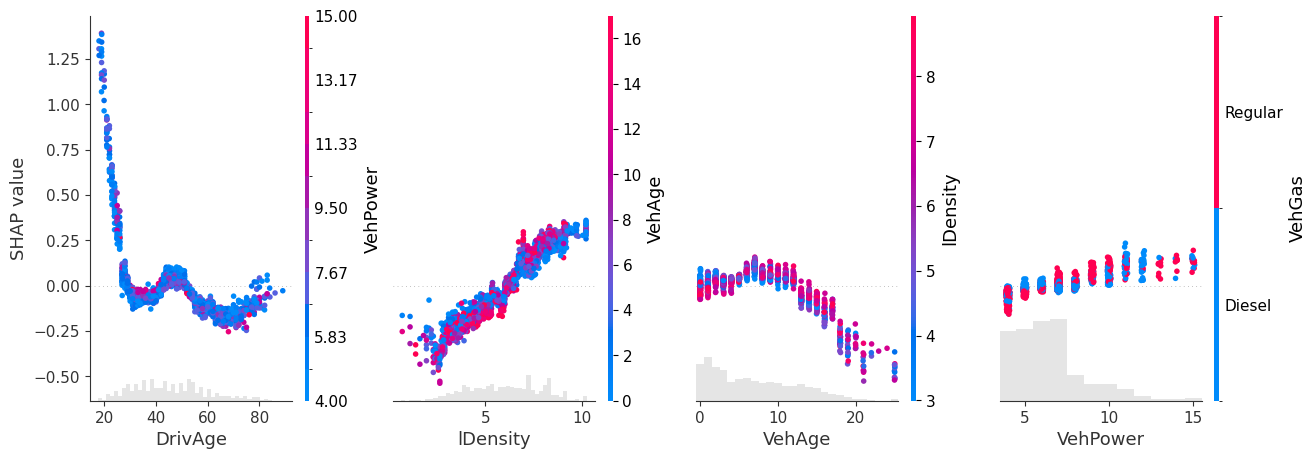

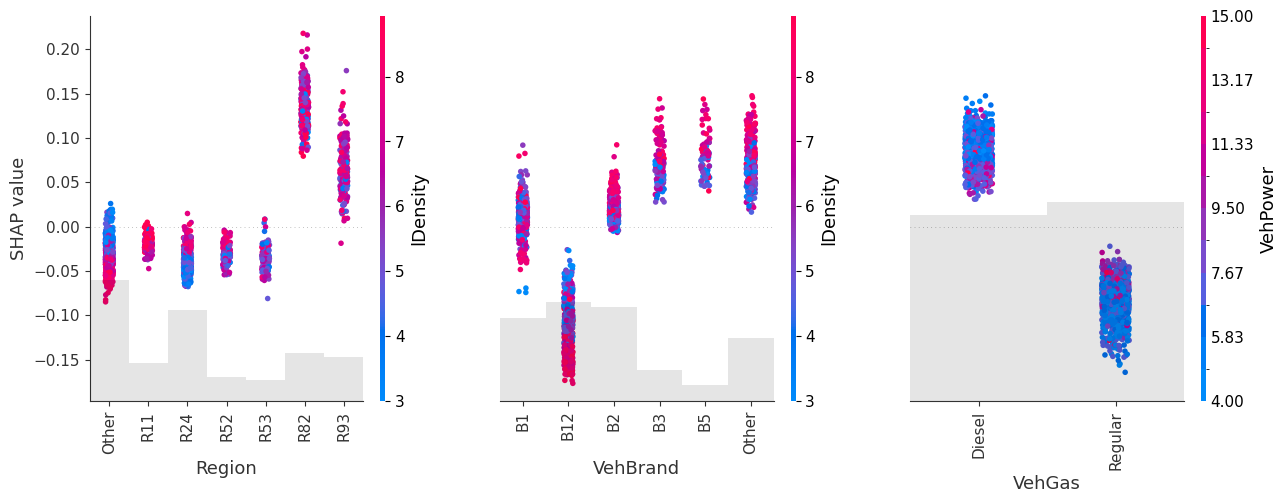

In [15]:
X_display = learn.sample(2000, random_state=1)  # , weights=train["Exposure"]
X_explain = preprocessor.transform(X_display)
explainer_freq = shap.Explainer(lgb_freq)
shap_freq = explainer_freq(X_explain)
shap_freq.display_data = X_display[X_explain.columns]  # For dependence plots

shap.plots.bar(shap_freq)
shap.plots.beeswarm(shap_freq)
shap.plots.scatter(shap_freq[:, 0:4], color=shap_freq)
shap.plots.scatter(shap_freq[:, 4:], color=shap_freq)

## Severity model
We fit a gamma model to the positive claims severities

In [16]:
learn_sev = learn[learn.ClaimNb > 0]

In [19]:
# Parameters again found by randomized search CV (tuning not shown)
params_sev = {
    "objective": "gamma",    # gamma distribution
    "learning_rate": 0.02,
    "num_leaves": 2,         # additive model on log link scale
    "reg_lambda": 2.5,
    "reg_alpha": 5,
    "colsample_bynode": 0.8,
    "subsample": 1,
    "min_child_samples": 50,
    "min_split_gain": 0.001,
}
nrounds_sev = 539

lgb_sev = LGBMRegressor(
    **params_sev, n_estimators=nrounds_sev, importance_type="gain", random_state=5
)
model_sev = Pipeline([("preprocessor", preprocessor), ("model", lgb_sev)])

# Fit model
_ = model_sev.fit(
    X=learn_sev, y=learn_sev.severity, model__sample_weight=learn_sev.ClaimNb
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 386
[LightGBM] [Info] Number of data points in the train set: 22434, number of used features: 7
[LightGBM] [Info] Start training from score 7.490949


We plot the variable importance measure from this gamma severity GBM.
Note that not all variables have been used in the splitting procedure.

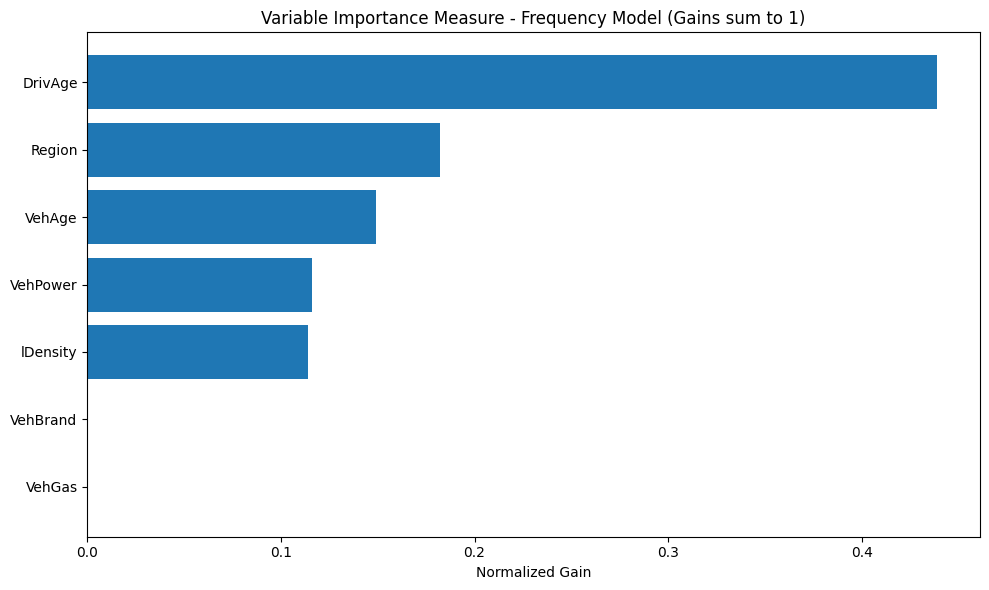

In [20]:
# Get feature importance values
importance_values = model_sev[-1].feature_importances_
# Normalize the importance values
importance_values = importance_values / importance_values.sum()

# Sort values and names in ascending order
sorted_idx = importance_values.argsort()  # Get indices for ascending order
sorted_values = importance_values[sorted_idx]
sorted_names = [model_sev[-1].feature_name_[i] for i in sorted_idx]

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_values)), sorted_values)
plt.yticks(range(len(sorted_values)), sorted_names)
plt.xlabel('Normalized Gain')
plt.title('Variable Importance Measure - Frequency Model (Gains sum to 1)')
plt.tight_layout()
plt.show()

### SHAP analysis

Using the same data as the frequency model in order to be able to combine with freqency model.

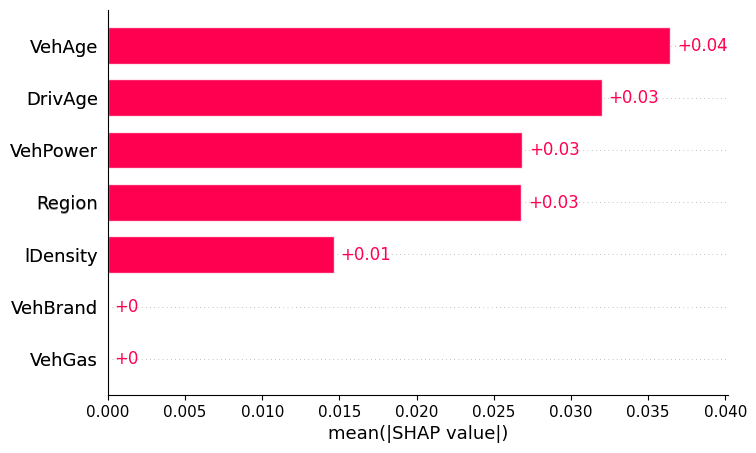

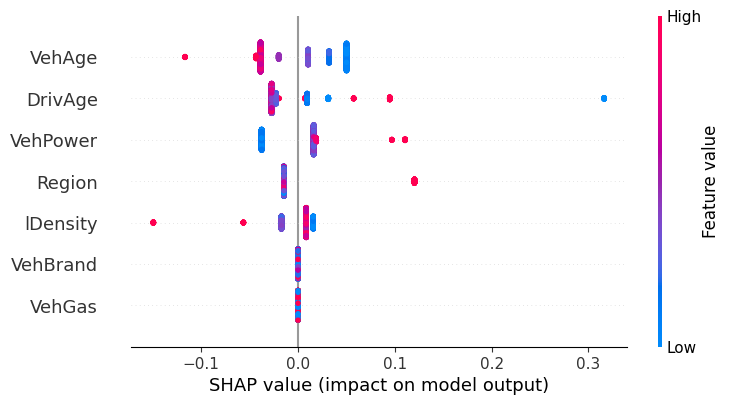

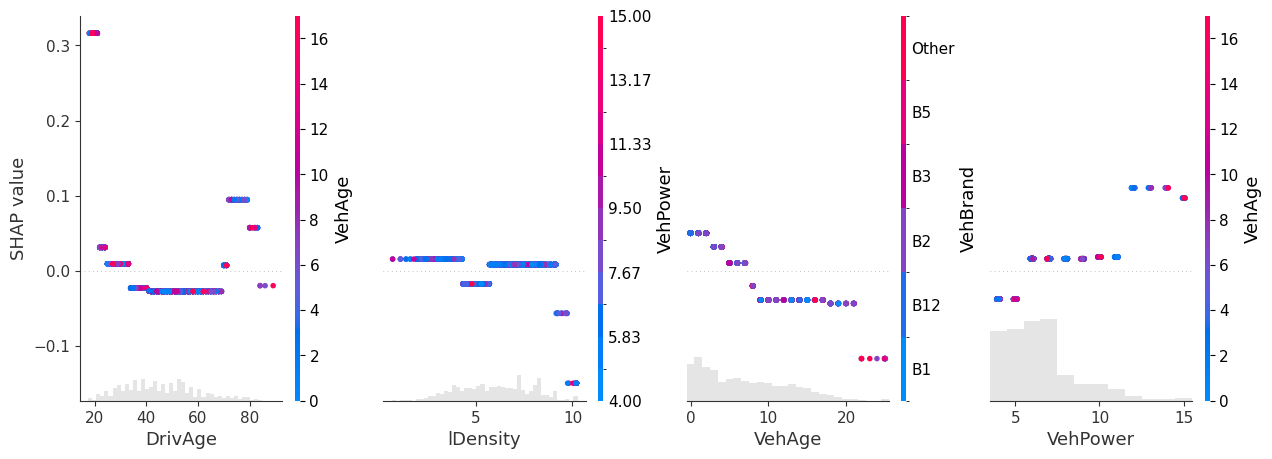

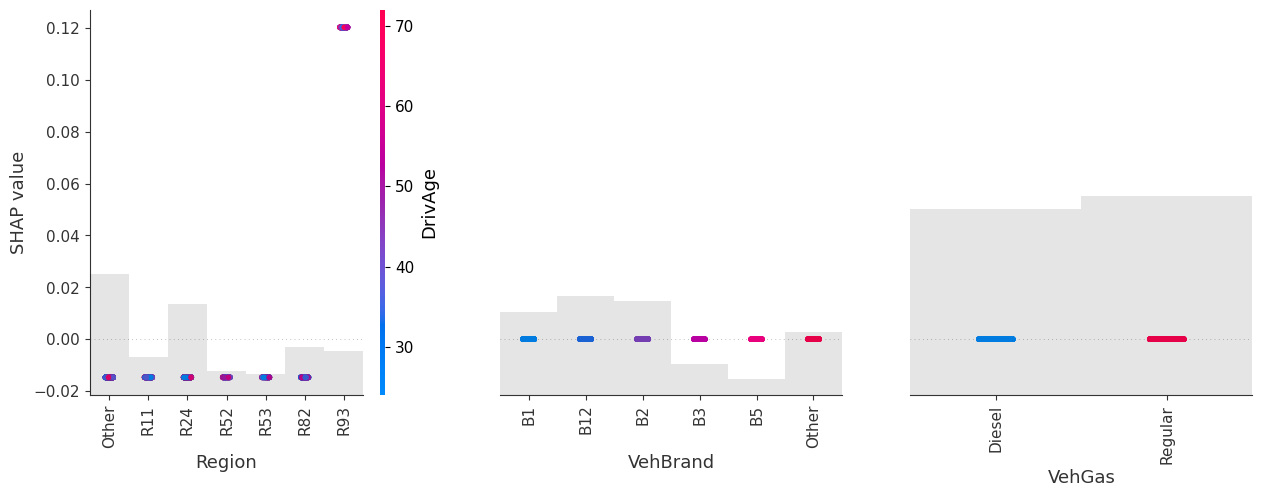

In [21]:
explainer_sev = shap.Explainer(lgb_sev)
shap_sev = explainer_sev(X_explain)
shap_sev.display_data = X_display[X_explain.columns]  # For dependence plots

shap.plots.bar(shap_sev)
shap.plots.beeswarm(shap_sev)
shap.plots.scatter(shap_sev[:, 0:4], color=shap_sev)
shap.plots.scatter(shap_sev[:, 4:], color=shap_sev)

## Pure risk premium model (SHAP analysis only)

Let's sum up the SHAP values from both models to get SHAP values for the combined
pure premium = frequency * severity model. For models with different features, 
some additional code would be required.


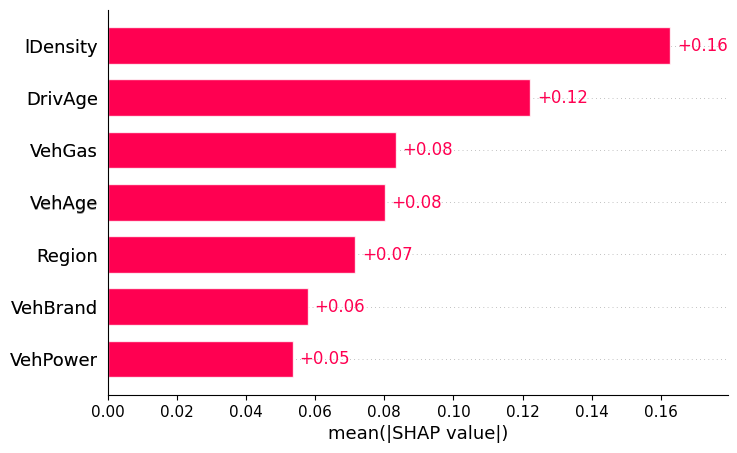

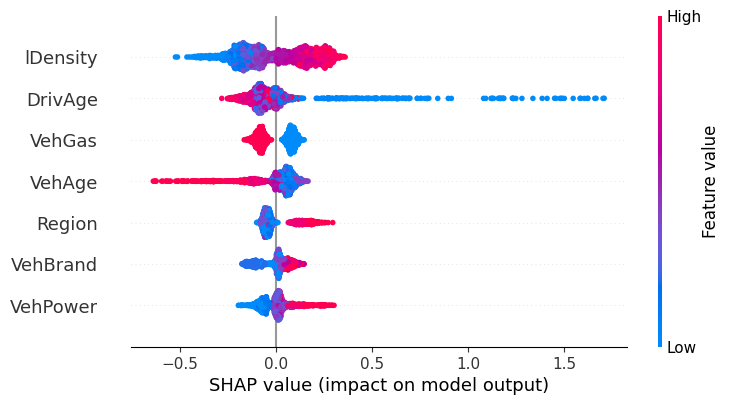

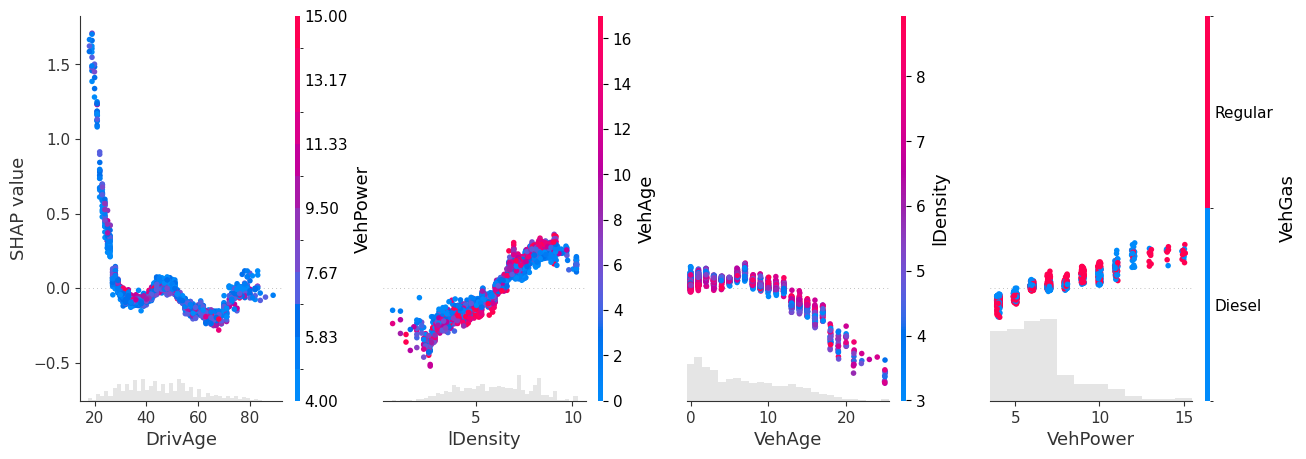

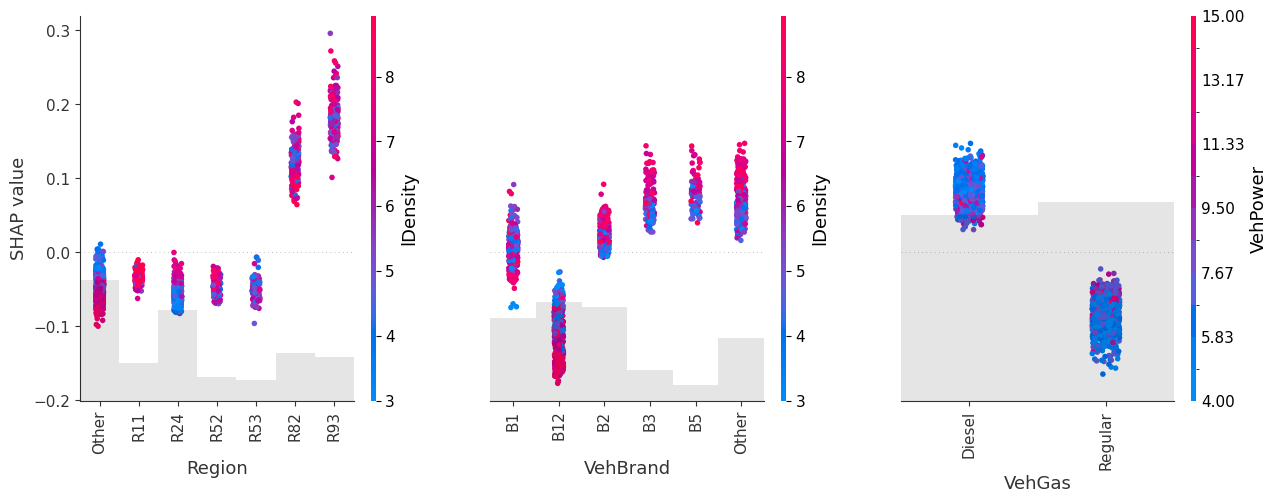

In [22]:
shap_pp = shap.Explanation(
    values=shap_freq.values + shap_sev.values,  # noqa: PD011
    base_values=shap_freq.base_values + shap_sev.base_values,
    data=shap_freq.data,
    display_data=shap_freq.display_data,
    feature_names=shap_freq.feature_names,
)

shap.plots.bar(shap_pp)
shap.plots.beeswarm(shap_pp)
shap.plots.scatter(shap_pp[:, 0:4], color=shap_pp)
shap.plots.scatter(shap_pp[:, 4:], color=shap_pp)